Seberapa besar variasi data?

Apakah mask-nya valid?

Apakah ada bias?

Apakah ada masalah resolusi?

Apakah flood area dominan kecil atau besar?

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import cv2
import joblib

## Preview Data

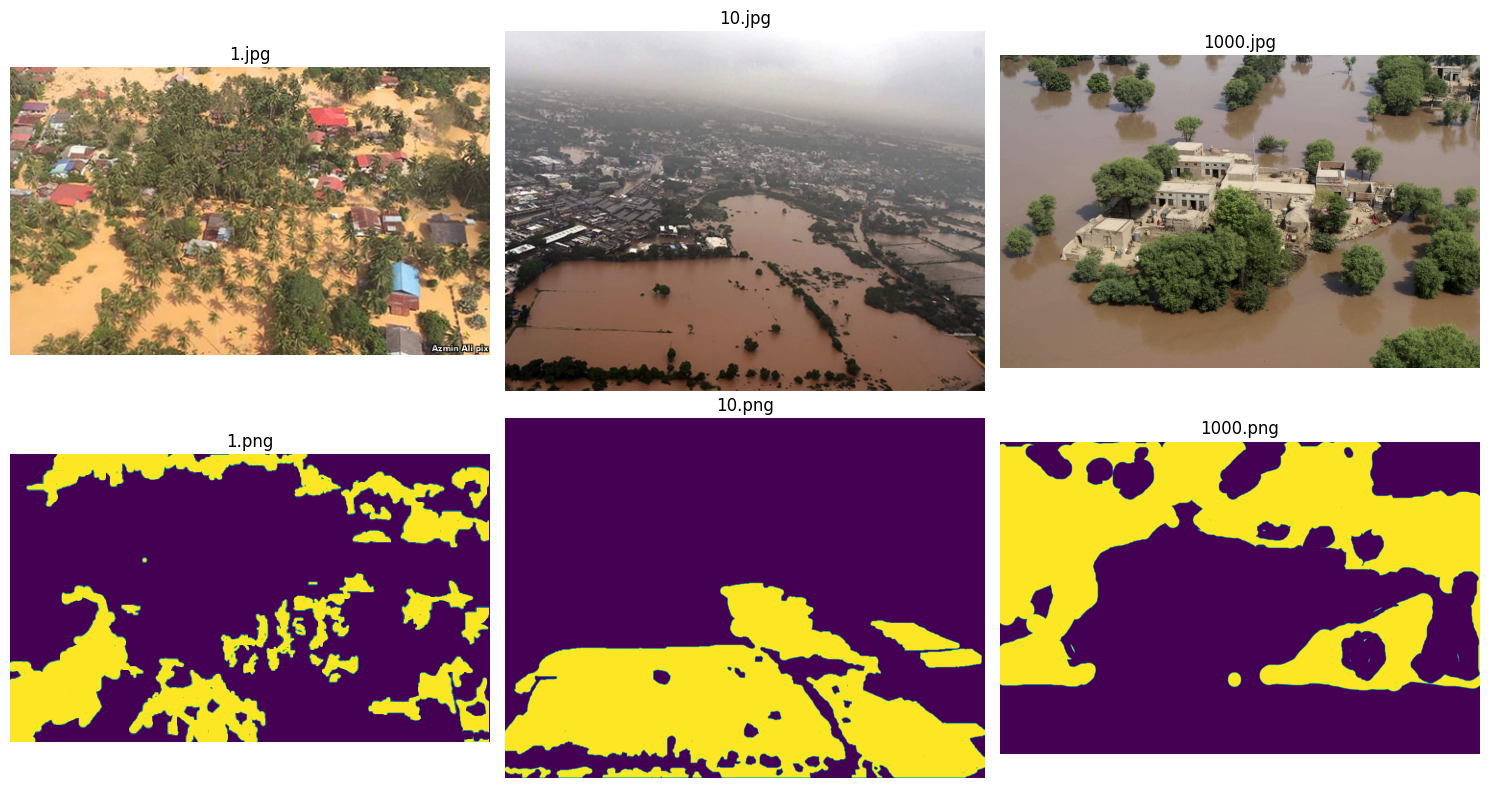

In [14]:
IMAGE_DIR = '../data/Image'
MASK_DIR = '../data/Mask'

def display_img(image_dir, mask_dir, n=3):
    img_files = os.listdir(image_dir)[:n]
    mask_files = os.listdir(mask_dir)[:n]
    fig, axes = plt.subplots(2, n, figsize=(5*n, 8))

    for i, fname in enumerate(img_files):
        img = Image.open(os.path.join(image_dir, fname))
        axes[0, i].set_title(fname)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

    for i, fname in enumerate(mask_files):
        mask = Image.open(os.path.join(mask_dir, fname))
        axes[1, i].set_title(fname)
        axes[1, i].imshow(mask)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_img(IMAGE_DIR, MASK_DIR)

## Variasi Data

In [15]:
var_img = os.listdir(IMAGE_DIR)
var_mask = os.listdir(MASK_DIR)
print(f'Gambar dalam folder {IMAGE_DIR} : {len(var_img)}')
print(f'Mask dalam folder {MASK_DIR} : {len(var_mask)}')

Gambar dalam folder ../data/Image : 289
Mask dalam folder ../data/Mask : 289


In [16]:
img = cv2.imread("../data/Image/12.jpg")
mask = cv2.imread("../data/Mask/12.png", 0)

print("path:", "../data/Image/12.jpg")
print("exists:", os.path.exists("../data/Image/12.jpg"))
print("img is None:", img is None)
print("shape:", None if img is None else img.shape)
print("dtype:", None if img is None else img.dtype)
print("min/max:", None if img is None else (img.min(), img.max()))


path: ../data/Image/12.jpg
exists: True
img is None: False
shape: (1425, 1900, 3)
dtype: uint8
min/max: (0, 255)


## Overlay

Saved overlay image to ../data/Overlay\1.jpg
Saved overlay image to ../data/Overlay\10.jpg
Saved overlay image to ../data/Overlay\1000.jpg


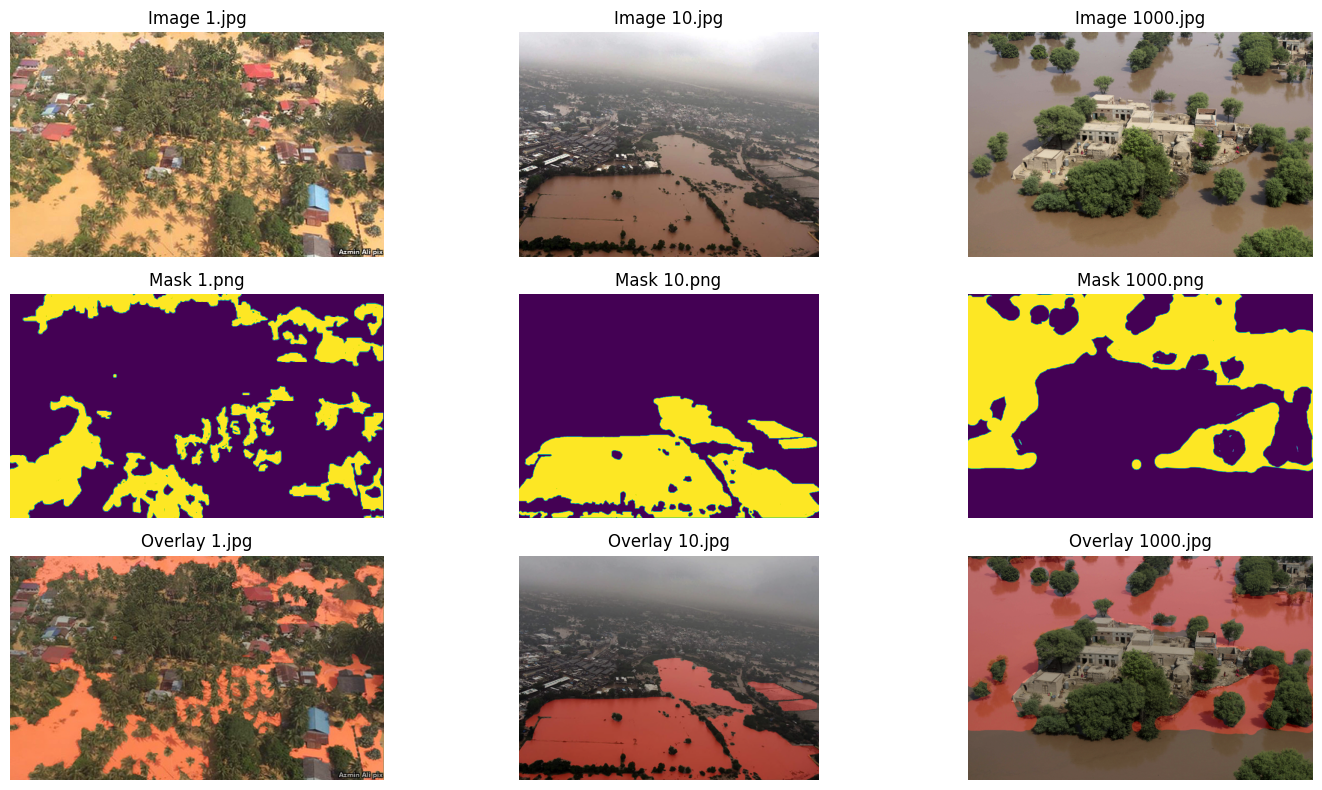

In [27]:


IMAGE_DIR = '../data/Image'
MASK_DIR = '../data/Mask'

def display_img(image_dir, mask_dir, n=3):
    img_files = sorted(os.listdir(image_dir))[:n]
    mask_files = sorted(os.listdir(mask_dir))[:n]
    fig, axes = plt.subplots(3, n, figsize=(5*n, 8))

    for i, fname in enumerate(img_files):
        img = Image.open(os.path.join(image_dir, fname))
        axes[0, i].set_title(f'Image {fname}')
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

    for i, fname in enumerate(mask_files):
        mask = Image.open(os.path.join(mask_dir, fname))
        axes[1, i].set_title(f'Mask {fname}')
        axes[1, i].imshow(mask)
        axes[1, i].axis('off')

    #menggunakan overlay function untuk menampilkan overlay img dan mask

    for i in range(n):
        img_path = os.path.join(image_dir, img_files[i])
        mask_path = os.path.join(mask_dir, mask_files[i])

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            axes[2, i].text(0.5, 0.5, 'Image not found', ha='center')
            axes[2, i].axis('off')
            continue

        if mask is None:
            mask = np.zeros(img.shape[:2], dtype=np.uint8)

        if mask.shape != img.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        if mask.dtype != np.uint8:
            if mask.max() <= 1:
                mask = (mask * 255).astype(np.uint8)
            else:
                mask = mask.astype(np.uint8)
        color = (0, 0, 255)  # BGR
        mask_norm = (mask / 255.0)[:, :, None]
        mask_colored = (mask_norm * np.array(color, dtype=np.float32)).astype(np.uint8)
        overlayed = cv2.addWeighted(img, 0.7, mask_colored, 0.3, 0)

        axes[2, i].set_title(f'Overlay {img_files[i]}')
        axes[2, i].imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
        axes[2, i].axis('off')

        #simpan gambar overlay ke ../data/Overlay
        overlay_dir = '../data/Overlay'
        if not os.path.exists(overlay_dir):
            os.makedirs(overlay_dir)
        overlay_path = os.path.join(overlay_dir, img_files[i])
        cv2.imwrite(overlay_path, overlayed)
        print(f'Saved overlay image to {overlay_path}')

    plt.tight_layout()
    plt.show()

display_img(IMAGE_DIR, MASK_DIR)

## Mask Analysis

rasio pixel positif
distribusi ukuran area banjir

In [18]:
### Mask analysis: unique values, positive pixel ratio, and flood-area distribution
mask_files = sorted([f for f in os.listdir(MASK_DIR) if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))])
print(f'Found {len(mask_files)} mask files in {MASK_DIR}')
results = []
areas_all = []
unique_summary = {}
for fname in mask_files:
    path = os.path.join(MASK_DIR, fname)
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print('Warning: could not read', path)
        continue
    u, counts = np.unique(mask, return_counts=True)
    unique_summary[fname] = dict(zip(u.tolist(), counts.tolist()))
    positive = int(np.count_nonzero(mask > 0))
    total = int(mask.size)
    ratio = positive / total
    # connected components to measure flood-area sizes (in pixels)
    bin_mask = (mask > 0).astype('uint8')
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)
    areas = []
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA].tolist()
        areas_all.extend(areas)
    results.append({'file': fname, 'positive': positive, 'total': total, 'ratio': float(ratio), 'components': len(areas), 'areas': areas})

df = pd.DataFrame(results)
print('\nSummary of positive pixel ratio per image:')
print(df['ratio'].describe())
print('\nSample unique values (first 5 files):')
for k in list(unique_summary.keys())[:5]:
    print(k, unique_summary[k])


Found 289 mask files in ../data/Mask

Summary of positive pixel ratio per image:
count    289.000000
mean       0.413495
std        0.195932
min        0.043993
25%        0.262438
50%        0.380152
75%        0.553407
max        0.881221
Name: ratio, dtype: float64

Sample unique values (first 5 files):
1.png {0: 109698, 2: 1, 4: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 2, 11: 1, 13: 2, 15: 4, 16: 368, 17: 1, 18: 2, 19: 2, 20: 1, 21: 3, 22: 2, 23: 3, 24: 2, 26: 3, 28: 2, 31: 11, 32: 308, 34: 1, 35: 1, 36: 1, 37: 2, 39: 1, 41: 2, 42: 7, 44: 1, 46: 3, 47: 2, 48: 278, 49: 1, 50: 1, 56: 1, 58: 1, 59: 1, 60: 4, 61: 3, 63: 124, 64: 392, 67: 1, 70: 4, 71: 1, 72: 3, 73: 2, 74: 1, 75: 3, 76: 5, 77: 1, 79: 32, 80: 171, 81: 3, 82: 4, 83: 1, 84: 1, 85: 2, 86: 2, 87: 2, 88: 6, 89: 1, 90: 1, 91: 3, 92: 1, 93: 1, 95: 30, 96: 166, 97: 1, 99: 2, 100: 5, 101: 1, 102: 2, 106: 3, 107: 2, 108: 1, 109: 1, 110: 2, 111: 49, 112: 162, 113: 1, 114: 1, 115: 1, 116: 2, 118: 3, 120: 2, 122: 1, 123: 2, 124: 3, 126: 2, 127

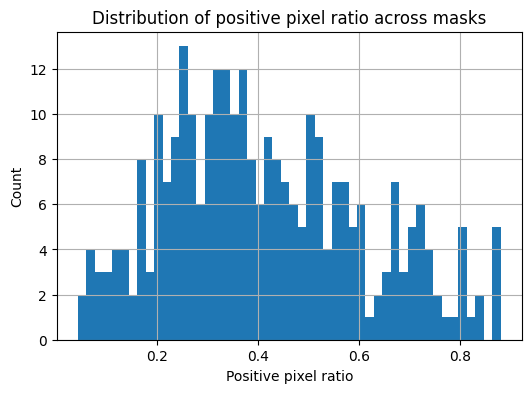

In [19]:

# Plot distribution of positive-pixel ratio
plt.figure(figsize=(6,4))
plt.hist(df['ratio'], bins=50, color='C0')
plt.xlabel('Positive pixel ratio')
plt.ylabel('Count')
plt.title('Distribution of positive pixel ratio across masks')
plt.grid(True)
plt.show()




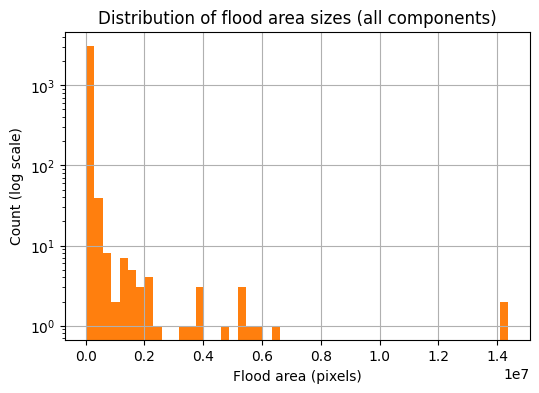


Flood area stats (pixels):
count: 3203
mean: 57022.10053075242
median: 113.0
min/max: 1 14384081

Saved mask statistics to ../result\mask_stats.csv


In [20]:
# Plot distribution of flood-area sizes (across all images)
if len(areas_all) > 0:
    plt.figure(figsize=(6,4))
    plt.hist(areas_all, bins=50, color='C1', log=True)
    plt.xlabel('Flood area (pixels)')
    plt.ylabel('Count (log scale)')
    plt.title('Distribution of flood area sizes (all components)')
    plt.grid(True)
    plt.show()
    areas_np = np.array(areas_all)
    print('\nFlood area stats (pixels):')
    print('count:', areas_np.size)
    print('mean:', areas_np.mean())
    print('median:', np.median(areas_np))
    print('min/max:', areas_np.min(), areas_np.max())
else:
    print('No flood components found in masks.')

# Save per-image summary to ../result/mask_stats.csv
out_dir = '../result'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
df.to_csv(os.path.join(out_dir, 'mask_stats.csv'), index=False)
print(f'\nSaved mask statistics to {os.path.join(out_dir, "mask_stats.csv")}')